# **Modelos ARIMA**
- **AR (p) - Auto Regressivo:** $y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... \phi_p y_{t-p} + e_t$
- **MA (q) - Média Móvel:** $y_t = c  + e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2} + ... \theta_q y_{t-q}$
- **ARIMA (p,d,q):** $y^{'}_t = c + \phi_1 y^{'}_{t-1} + \phi_2 y^{'}_{t-2} + ... \phi_p y^{'}_{t-p} + \theta_1 e_{t-1} + \theta_2 e_{t-2} + ... \theta_q y_{t-q} + e_t$

sendo que $p$ é a ordem do modelos **AR**, $q$ é a ordem do modelo **MA**, e $d$ é o grau de diferenciação.

# **Air passengers**

## **Pré-Processamento**

### **Preparando o ambiente**

In [1]:
#Instalando biblioteca necessária
#!pip install pmdarima

In [2]:
# Importando biblioteca necessária
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima


### **Carregando o conjunto de dados**

In [4]:
# Importando o conjunto de dados de passageiros de avião d

file = 'https://raw.githubusercontent.com/rogeriodelfim/Dataset/main/Passageiros/passageiros.csv'
passageiros = pd.read_csv(
    filepath_or_buffer = file, 
    sep=','
)

In [5]:
# Espiando a estrutura conjunto de dados
passageiros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ano_mes      144 non-null    object
 1   passageiros  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


### **Transformando o conjunto de dados**

In [6]:
# Transferindo a coluna ano_mes para o índice
passageiros = passageiros.set_index('ano_mes')

In [7]:
# Espiando o resultado
passageiros

,passageiros
ano_mes,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
...,...
1960-08,606
1960-09,508
1960-10,461


In [8]:
# Alterando o tipo do índice para DatetimeIndex com frequência mensal
passageiros.index = pd.DatetimeIndex(passageiros.index ,freq='MS')

In [9]:
# Verificando o tipo do índice do dataframe
passageiros.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='ano_mes', length=144, freq='MS')

In [10]:
# Criando a  Serie temporal
st_passageiros_completa = pd.Series(
    data = passageiros['passageiros'].values, 
    index = passageiros.index
)

# Espiando o resultado
st_passageiros_completa

ano_mes
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Freq: MS, Length: 144, dtype: int64

In [11]:
# Criando a  Serie temporal de treino
st_passageiros = pd.Series(
    data = passageiros.query('ano_mes<"1960-01-01"')['passageiros'].values, 
    index = passageiros.query('ano_mes<"1960-01-01"').index
)

# Espiando o resultado da Serie temporal de treino
st_passageiros

ano_mes
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1959-08-01    559
1959-09-01    463
1959-10-01    407
1959-11-01    362
1959-12-01    405
Freq: MS, Length: 132, dtype: int64

In [12]:
# Criando a  Serie temporal de teste
st_passageiros_teste = pd.Series(
    data = passageiros.query('ano_mes>="1960-01-01"')['passageiros'].values, 
    index = passageiros.query('ano_mes>="1960-01-01"').index
)

# Espiando o resultado da Serie temporal de teste
st_passageiros_teste

ano_mes
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Freq: MS, dtype: int64

## **Análise Exploratória**

### **Visualização da Série**

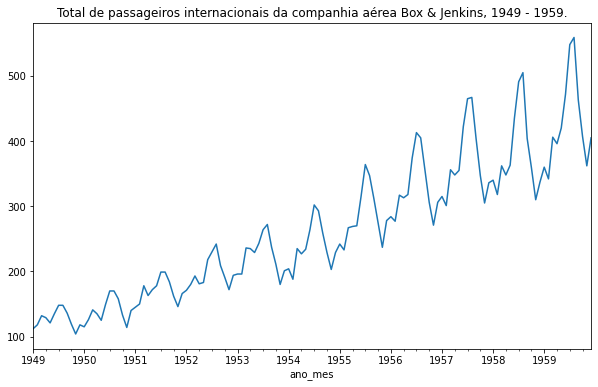

In [13]:
# Gerando o gráfico da Serie
st_passageiros.plot(
    title = 'Total de passageiros internacionais da companhia aérea Box & Jenkins, 1949 - 1959.',
    figsize =(10, 6)
);

### **Decomposição da série**

In [14]:
# Decompondo a série
decomposicao = seasonal_decompose(st_passageiros,model='multiplicative')

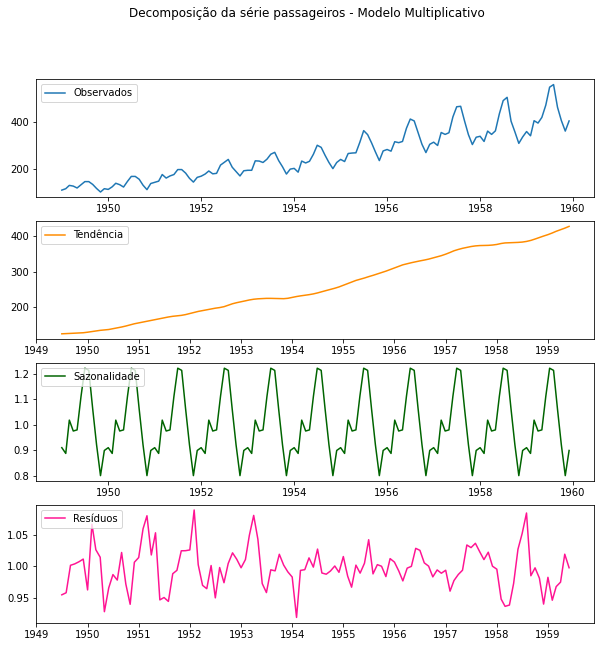

In [15]:
# Definindo o tamanho da figura
fig, ax = plt.subplots(figsize = (10,10), ncols = 1, nrows = 4)

# Gráfico com valores observados
ax[0].plot(decomposicao.observed, label='Observados')
ax[0].legend(loc='upper left')

# Gráfico com a tendência
ax[1].plot(decomposicao.trend, color = 'darkorange', label='Tendência')
ax[1].legend(loc='upper left')

# Gráfico com a Sazonalidade
ax[2].plot(decomposicao.seasonal, color = 'darkgreen', label='Sazonalidade')
ax[2].legend(loc='upper left')

# Gráfico com os resíduos
ax[3].plot(decomposicao.resid, color = 'deeppink', label='Resíduos')
ax[3].legend(loc='upper left')

# Alterando o título
fig.suptitle('Decomposição da série passageiros - Modelo Multiplicativo');

# Exibindo o gráfico
plt.show()

### **Teste de estacionaridade - (Dickey Fuller)**

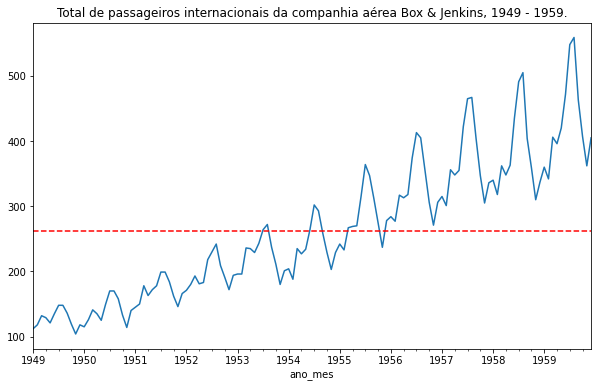

In [16]:
# Gerando o gráfico
st_passageiros.plot(
    title = 'Total de passageiros internacionais da companhia aérea Box & Jenkins, 1949 - 1959.',
    figsize =(10, 6)
)

# Inserindo uma linha horizontal com a média dos dados
plt.axhline (y=st_passageiros.mean(), color = 'red', linestyle = '--')

# Exibindo o gráfico
plt.show()

- **Hipótese nula (Ho):** a série *não é estacionária*
- **Hipótese Alternativa (Ha):** a série *é estacionária*

In [17]:
# Calculando as medidas do teste Dickey Fuller
df = statsmodels.tsa.stattools.adfuller(st_passageiros)

print('Estatítica do teste: {:.4f}'.format(df[0]))
print('p-valor do teste: {:.8f}'.format(df[1]))
print('Valores Críticos:')
for chave, valor in df[4].items():
   print('{}: {:.4f}'.format(chave, valor))

Estatítica do teste: 0.8880
p-valor do teste: 0.99293206
Valores Críticos:
1%: -3.4870
5%: -2.8864
10%: -2.5800


Como a estatística do teste é maior que o valor crítico podemos considerar que NÃO existem evidências suficientes para rejeitar a hipótese nula, ou seja, a nível de 1% de significância NÃO existem evidências de que a série é estacionária.

### **Diferenciação**

Uma estratégia para tornar uma série estacionária é fazer a diferenciação $y^{'}_t=y_t - y_{t-1}$, também chamada de série diferenciada de primeira ordem. Caso a série não se torne estacionária, pode diferenciar novamente até encontrar o **d** (grau de diferenciação) ótimo.

In [18]:
# Encontrando a diferença de primeira ordem
st_passageiros_1_dif = st_passageiros.diff()

# Retirando o NA gerado pela falta de valores antes da primeira observação
st_passageiros_1_dif.dropna(inplace = True)

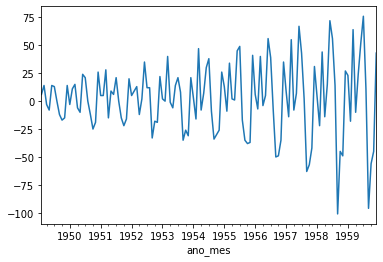

In [19]:
# Gerando o gráfico
st_passageiros_1_dif.plot()
plt.show()

In [20]:
# Calculando as medidas do teste Dickey Fuller
# **Hipótese nula (Ho):** a série *não é estacionária*
# **Hipótese Alternativa (Ha):** a série *é estacionária*
df = statsmodels.tsa.stattools.adfuller(st_passageiros_1_dif)

print('Estatítica do teste: {:.4f}'.format(df[0]))
print('p-valor do teste: {:.8f}'.format(df[1]))
print('Valores Críticos:')
for chave, valor in df[4].items():
   print('{}: {:.4f}'.format(chave, valor))

Estatítica do teste: -2.4029
p-valor do teste: 0.14091389
Valores Críticos:
1%: -3.4875
5%: -2.8866
10%: -2.5801


### **Auto Correlação da série diferenciada**

d:\virtualenv\kaggle\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


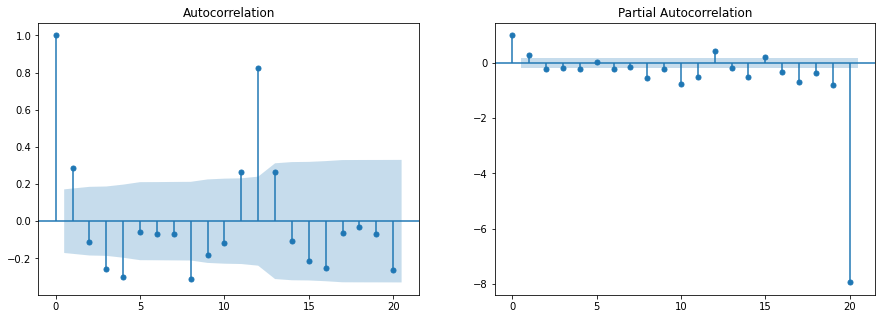

In [21]:
# Definindo o tamanho da figura e disposições dos subplots
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

 # Fazendo o gráfico de autocorrelação e autocorrelação  parcial
plot_acf(st_passageiros_1_dif, lags=20, ax=ax[0])
plot_pacf(st_passageiros_1_dif, lags=20, ax=ax[1])

# Exibindo o gráfico
plt.show()

## **Modelos Box-Jenkins das série original**

### **Modelo ARIMA(1,0,0) = AR(1)**

Um modelo ARIMA (p,d,q) com a ordem da média móvel e o grau de diferenciação iguais a zero temos ARIMA(p,0,0) resulta em um modelo auto regressivo de ordem p: AR(p).

In [22]:
# Definindo Ajustando um modelo ARIMA(1,1,0)
modelo_arima_1_0_0 = ARIMA(st_passageiros, order = (1,0,0))

In [23]:
# Ajustando o modelo e guardando os resultado em um objeto
resultado_arima_1_0_0 = modelo_arima_1_0_0.fit()

In [24]:
# Pegando os resíduos do modelo
residuos_arima_1_0_0 = resultado_arima_1_0_0.resid

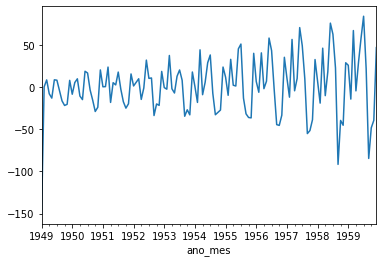

In [25]:
# Visualizando os resíduos
residuos_arima_1_0_0.plot()
plt.show()

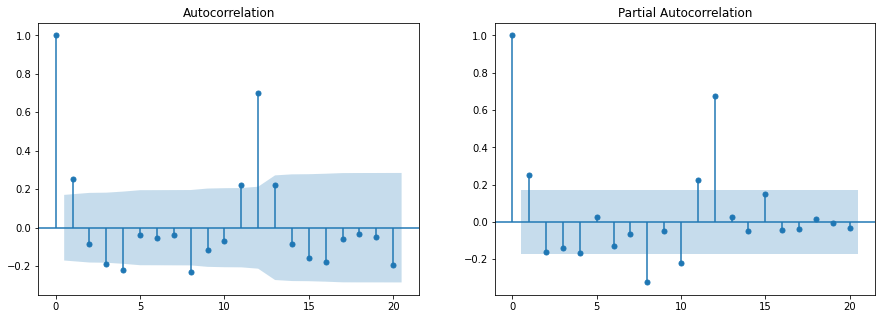

In [26]:
# Definindo o tamanho da figura e disposições dos subplots
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

 # Fazendo o gráfico de autocorrelação e autocorrelação  parcial
plot_acf(residuos_arima_1_0_0, lags=20, ax=ax[0])
plot_pacf(residuos_arima_1_0_0, lags=20, ax=ax[1])

# Exibindo o gráfico
plt.show()

C:\Users\roger\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


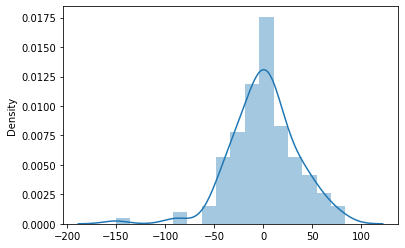

In [27]:
# Visualizando a distribuição dos resíduos
sns.distplot(residuos_arima_1_0_0);

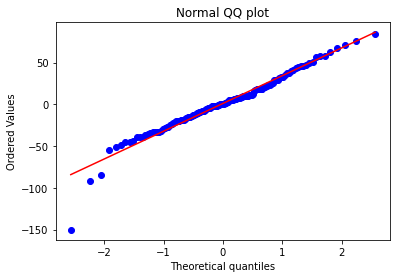

In [29]:
# Verificando a normalidade dos resíduos através do QQ plot
stats.probplot(residuos_arima_1_0_0, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

In [30]:
# Testando a normalidade dos resíduos
# Ho = distribuição normal p > 0,05
# Ha = distribuição não normal p <= 0,05

e, p = stats.shapiro(residuos_arima_1_0_0)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9638496041297913
p-valor: 0.0013985694386065006


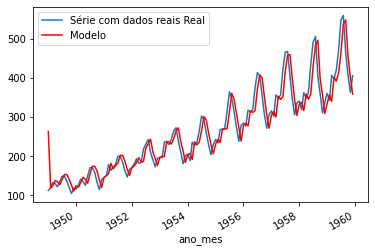

In [31]:
# Plotando a série com dados reais e ajustados pelo modelo
plt.plot(st_passageiros, label='Série com dados reais Real')
resultado_arima_1_0_0.predict().plot(color='red', label='Modelo')
plt.legend(loc='best')
plt.show()

### **Modelo ARIMA(0,0,1) = MA(1)**

Um modelo ARIMA (p,d,q) com a ordem da auto regressivo e o grau de diferenciação iguais a zero temos ARIMA(0,0,q) resulta em um modelo de média móvel de ordem q: MA(q). 

d:\virtualenv\kaggle\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


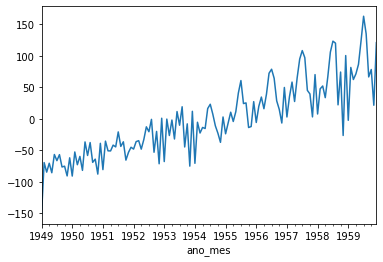

In [32]:
# Definindo Ajustando um modelo ARIMA(0,0,1)
modelo_arima_0_0_1 = ARIMA(st_passageiros, order = (0,0,1))

# Ajustando o modelo e guardando os resultado em um objeto
resultado_arima_0_0_1 = modelo_arima_0_0_1.fit()

# Pegando os resíduos do modelo
residuos_arima_0_0_1 = resultado_arima_0_0_1.resid

# Visualizando os resíduos
residuos_arima_0_0_1.plot()
plt.show()

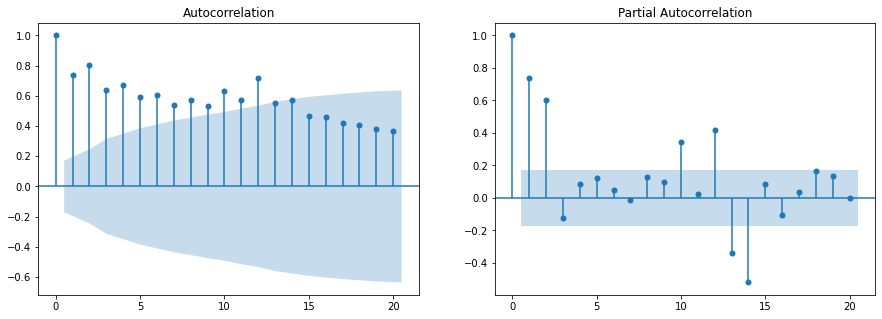

In [33]:
# Definindo o tamanho da figura e disposições dos subplots
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

 # Fazendo o gráfico de autocorrelação e autocorrelação  parcial
plot_acf(residuos_arima_0_0_1, lags=20, ax=ax[0])
plot_pacf(residuos_arima_0_0_1, lags=20, ax=ax[1])

# Exibindo o gráfico
plt.show()

C:\Users\roger\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


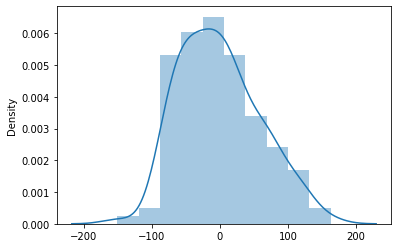

In [34]:
# Visualizando a distribuição dos resíduos
sns.distplot(residuos_arima_0_0_1);

In [35]:
# Testando a normalidade dos resíduos
# Ho = distribuição normal p > 0,05
# Ha = distribuição não normal p <= 0,05

e, p = stats.shapiro(residuos_arima_0_0_1)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9767767786979675
p-valor: 0.023148350417613983


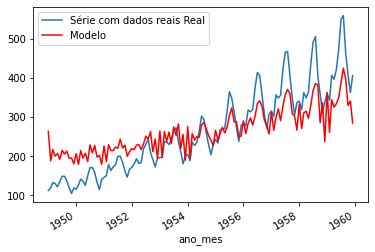

In [36]:
# Plotando a série com dados reais e ajustados pelo modelo
plt.plot(st_passageiros, label='Série com dados reais Real')
resultado_arima_0_0_1.predict().plot(color='red', label='Modelo')
plt.legend(loc='best')
plt.show()

### **Modelo ARIMA(1,0,1) = ARMA(1,1)**

Um modelo ARIMA (p,d,q) com o grau de diferenciação igual a zero temos ARIMA(p,0,q) resulta em um modelo Auto regressivo e de média móvel de ordem p,q: ARMA(p,q).

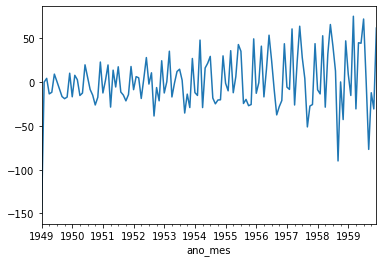

In [37]:
# Definindo Ajustando um modelo ARIMA(1,0,1)
modelo_arima_1_0_1 = ARIMA(st_passageiros, order = (1,0,1))

# Ajustando o modelo e guardando os resultado em um objeto
resultado_arima_1_0_1 = modelo_arima_1_0_1.fit()

# Pegando os resíduos do modelo
residuos_arima_1_0_1 = resultado_arima_1_0_1.resid

# Visualizando os resíduos
residuos_arima_1_0_1.plot()
plt.show()

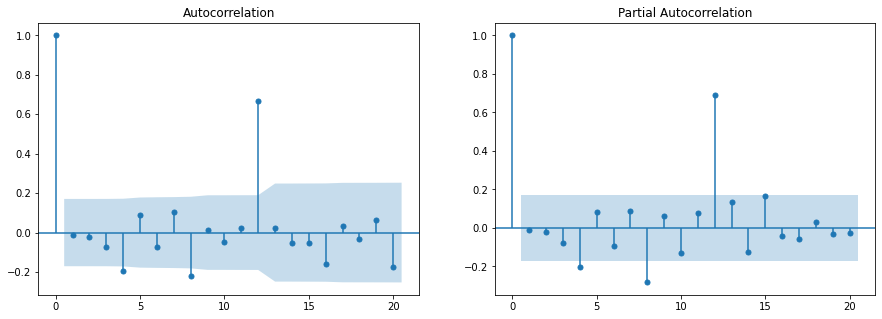

In [38]:
# Definindo o tamanho da figura e disposições dos subplots
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

 # Fazendo o gráfico de autocorrelação e autocorrelação  parcial
plot_acf(residuos_arima_1_0_1, lags=20, ax=ax[0])
plot_pacf(residuos_arima_1_0_1, lags=20, ax=ax[1])

# Exibindo o gráfico
plt.show()

C:\Users\roger\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


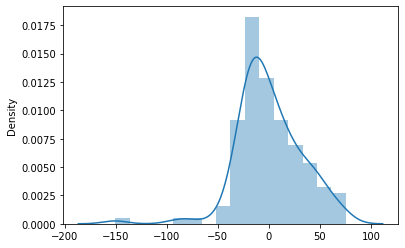

In [39]:
# Visualizando a distribuição dos resíduos
sns.distplot(residuos_arima_1_0_1);

In [40]:
# Testando a normalidade dos resíduos
# Ho = distribuição normal p > 0,05
# Ha = distribuição não normal p <= 0,05

e, p = stats.shapiro(residuos_arima_1_0_1)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9358697533607483
p-valor: 9.344216778117698e-06


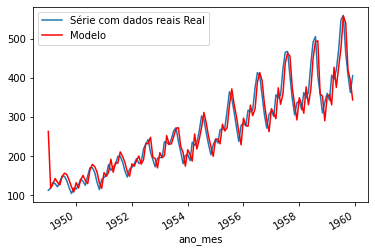

In [41]:
# Plotando a série com dados reais e ajustados pelo modelo
plt.plot(st_passageiros, label='Série com dados reais Real')
resultado_arima_1_0_1.predict().plot(color='red', label='Modelo')
plt.legend(loc='best')
plt.show()

### **Modelo ARIMA(1,1,1)**

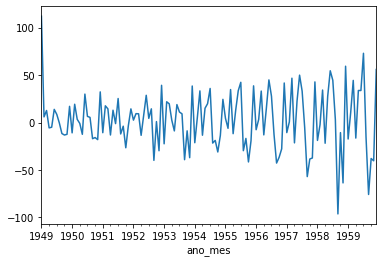

In [42]:
# Definindo Ajustando um modelo ARI(1) = ARIMA(1,1,1)
modelo_arima_1_1_1 = ARIMA(st_passageiros, order = (1,1,1))

# Ajustando o modelo e guardando os resultado em um objeto
resultado_arima_1_1_1 = modelo_arima_1_1_1.fit()

# Pegando os resíduos do modelo
residuos_arima_1_1_1 = resultado_arima_1_1_1.resid

# Visualizando os resíduos
residuos_arima_1_1_1.plot()
plt.show()

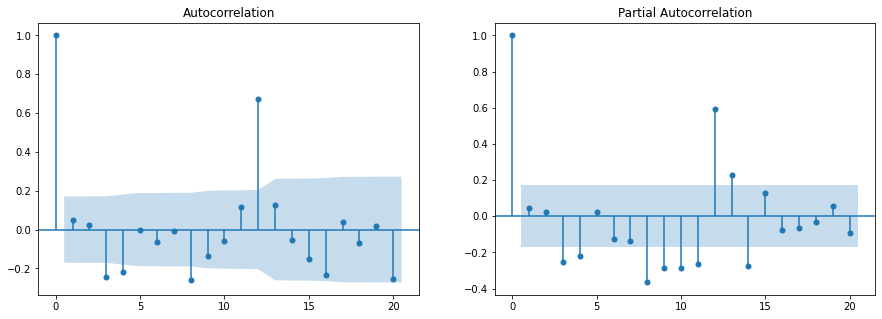

In [43]:
# Definindo o tamanho da figura e disposições dos subplots
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

 # Fazendo o gráfico de autocorrelação e autocorrelação  parcial
plot_acf(residuos_arima_1_1_1, lags=20, ax=ax[0])
plot_pacf(residuos_arima_1_1_1, lags=20, ax=ax[1])

# Exibindo o gráfico
plt.show()

C:\Users\roger\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


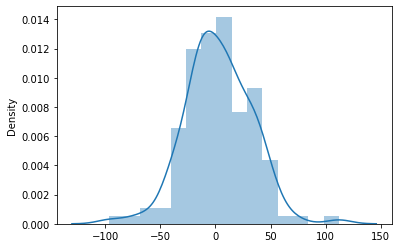

In [44]:
# Visualizando a distribuição dos resíduos
sns.distplot(residuos_arima_1_1_1);

In [45]:
# Testando a normalidade dos resíduos
# Ho = distribuição normal p > 0,05
# Ha = distribuição não normal p <= 0,05

e, p = stats.shapiro(residuos_arima_1_1_1)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9845232367515564
p-valor: 0.14032559096813202


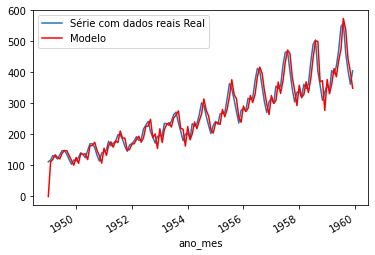

In [46]:
# Plotando a série com dados reais e ajustados pelo modelo
plt.plot(st_passageiros, label='Série com dados reais Real')
resultado_arima_1_1_1.predict().plot(color='red', label='Modelo')
plt.legend(loc='best')
plt.show()

### **Modelo ARIMA(1,0,1)(1,0,1)**

Um modelo ARIMA (p,d,q) com o grau de diferenciação igual a zero temos ARIMA(p,0,q) resulta em um modelo Auto regressivo e de média móvel de ordem p,q: ARMA(p,q). Para modelar também a sazonalidade insere os parâmetros (P,D,Q).

d:\virtualenv\kaggle\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


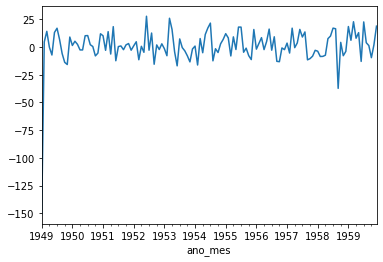

In [47]:
# Definindo Ajustando um modelo ARIMA(1,0,1)(1,0,1) com ajuste sazonal
modelo_arima_1_0_1_1_0_1 = statsmodels.tsa.arima.model.ARIMA(
    st_passageiros, 
    order = (1,0,1), 
    seasonal_order = (1, 0, 1, 12)
)

# Ajustando o modelo e guardando os resultado em um objeto
resultado_arima_1_0_1_1_0_1 = modelo_arima_1_0_1_1_0_1.fit()

# Pegando os resíduos do modelo
residuos_arima_1_0_1_1_0_1 = resultado_arima_1_0_1_1_0_1.resid

# Visualizando os resíduos
residuos_arima_1_0_1_1_0_1.plot()
plt.show()

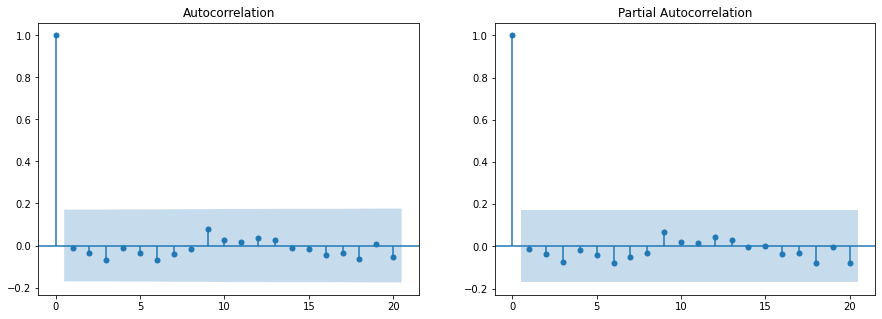

In [48]:
# Definindo o tamanho da figura e disposições dos subplots
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

 # Fazendo o gráfico de autocorrelação e autocorrelação  parcial
plot_acf(residuos_arima_1_0_1_1_0_1, lags=20, ax=ax[0])
plot_pacf(residuos_arima_1_0_1_1_0_1, lags=20, ax=ax[1])

# Exibindo o gráfico
plt.show()

C:\Users\roger\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


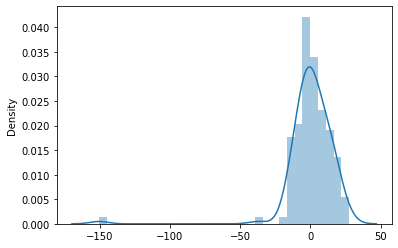

In [49]:
# Visualizando a distribuição dos resíduos
sns.distplot(residuos_arima_1_0_1_1_0_1);

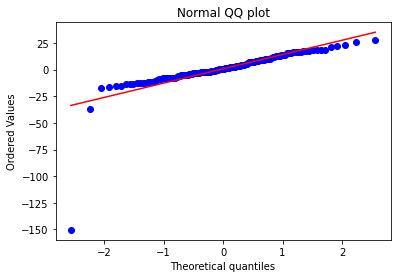

In [50]:
# Verificando a normalidade dos resíduos através do QQ plot
stats.probplot(residuos_arima_1_0_1_1_0_1, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

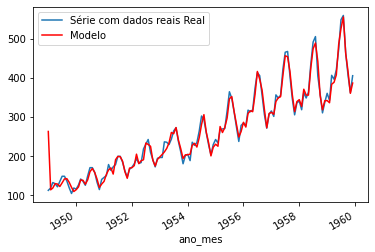

In [51]:
# Plotando a série com dados reais e ajustados pelo modelo
plt.plot(st_passageiros, label='Série com dados reais Real')
resultado_arima_1_0_1_1_0_1.predict().plot(color='red', label='Modelo')
plt.legend(loc='best')
plt.show()

### **Modelo ARIMA(1,1,1)(1,1,1)**

d:\virtualenv\kaggle\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


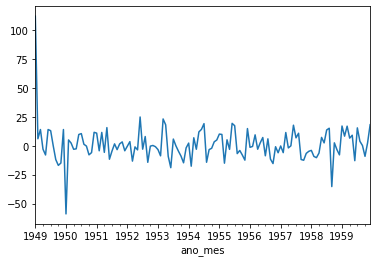

In [52]:
# Definindo Ajustando um modelo ARIMA(1,1,1)(1,1,1) com ajuste sazonal
modelo_arima_1_1_1_1_1_1 = statsmodels.tsa.arima.model.ARIMA(
    st_passageiros, 
    order = (1,1,1), 
    seasonal_order = (1, 1, 1, 12)
)

# Ajustando o modelo e guardando os resultado em um objeto
resultado_arima_1_1_1_1_1_1 = modelo_arima_1_1_1_1_1_1.fit()

# Pegando os resíduos do modelo
residuos_arima_1_1_1_1_1_1 = resultado_arima_1_1_1_1_1_1.resid

# Visualizando os resíduos
residuos_arima_1_1_1_1_1_1.plot()
plt.show()

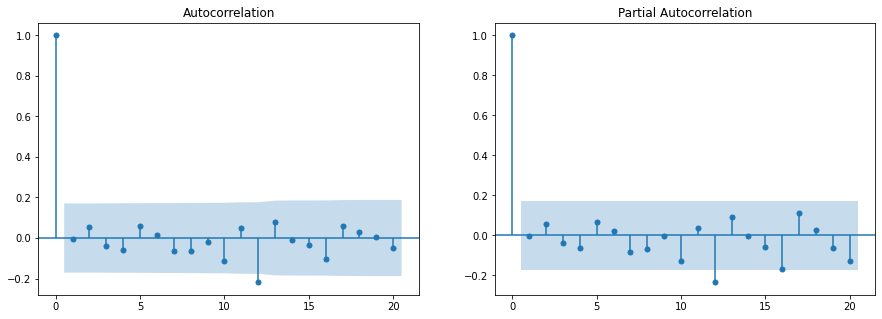

In [53]:
# Definindo o tamanho da figura e disposições dos subplots
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

 # Fazendo o gráfico de autocorrelação e autocorrelação  parcial
plot_acf(residuos_arima_1_1_1_1_1_1, lags=20, ax=ax[0])
plot_pacf(residuos_arima_1_1_1_1_1_1, lags=20, ax=ax[1])

# Exibindo o gráfico
plt.show()

C:\Users\roger\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


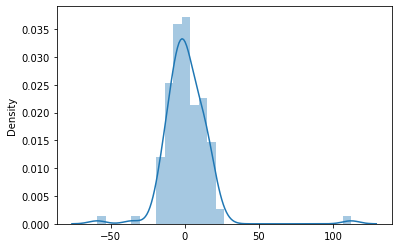

In [54]:
# Visualizando a distribuição dos resíduos
sns.distplot(residuos_arima_1_1_1_1_1_1);

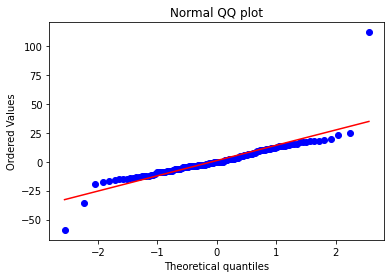

In [55]:
# Verificando a normalidade dos resíduos através do QQ plot
stats.probplot(residuos_arima_1_1_1_1_1_1, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

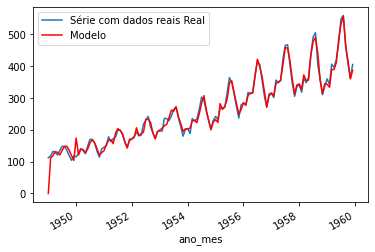

In [56]:
# Plotando a série com dados reais e ajustados pelo modelo
plt.plot(st_passageiros, label='Série com dados reais Real')
resultado_arima_1_1_1_1_1_1.predict().plot(color='red', label='Modelo')
plt.legend(loc='best')
plt.show()

### **Analisando o Critério de Informação de Akaike - AIC**

In [58]:
# Verificando o valor do Critério de Informação de Akaike - AIC
print('ARIMA(1,0,0): AIC = {}'.format(resultado_arima_1_0_0.aic))
print('ARIMA(0,0,1): AIC = {}'.format(resultado_arima_0_0_1.aic))
print('ARIMA(1,0,1): AIC = {}'.format(resultado_arima_1_0_1.aic))
print('ARIMA(1,1,1): AIC = {}'.format(resultado_arima_1_1_1.aic))
print('ARIMA(1,0,1)(1,0,1): AIC = {}'.format(resultado_arima_1_0_1_1_0_1.aic))
print('ARIMA(1,1,1)(1,1,1): AIC = {}'.format(resultado_arima_1_1_1_1_1_1.aic))

ARIMA(1,0,0): AIC = 1290.3759003853627
ARIMA(0,0,1): AIC = 1453.4999823827554
ARIMA(1,0,1): AIC = 1275.6232999395772
ARIMA(1,1,1): AIC = 1257.0352712018966
ARIMA(1,0,1)(1,0,1): AIC = 1038.2893962488574
ARIMA(1,1,1)(1,1,1): AIC = 901.399198240259


### **Previsão**

In [59]:
# Predizendo com o modelo AR(1)
previsao_arima_1_0_0 = resultado_arima_1_0_0.forecast(12)
previsao_arima_1_0_0

1960-01-01    399.554855
1960-02-01    394.317763
1960-03-01    389.280774
1960-04-01    384.436243
1960-05-01    379.776815
1960-06-01    375.295420
1960-07-01    370.985253
1960-08-01    366.839773
1960-09-01    362.852687
1960-10-01    359.017943
1960-11-01    355.329721
1960-12-01    351.782421
Freq: MS, Name: predicted_mean, dtype: float64

In [60]:
# Predizendo com o modelo ARIMA(1,0,1)(1,0,1)
previsao_arima_1_0_1_1_0_1 = resultado_arima_1_0_1_1_0_1.forecast(12)
previsao_arima_1_0_1_1_0_1

1960-01-01    420.822537
1960-02-01    401.092475
1960-03-01    459.263738
1960-04-01    447.362550
1960-05-01    467.838844
1960-06-01    517.266167
1960-07-01    587.141214
1960-08-01    596.080310
1960-09-01    501.841281
1960-10-01    446.977653
1960-11-01    401.837971
1960-12-01    440.598800
Freq: MS, Name: predicted_mean, dtype: float64

In [61]:
# Predizendo com o modelo ARIMA(1,1,1)(1,1,1)
previsao_arima_1_1_1_1_1_1 = resultado_arima_1_1_1_1_1_1.forecast(12)
previsao_arima_1_1_1_1_1_1

1960-01-01    421.879735
1960-02-01    405.448676
1960-03-01    464.710436
1960-04-01    453.487949
1960-05-01    477.285673
1960-06-01    534.860304
1960-07-01    609.486655
1960-08-01    621.618982
1960-09-01    522.649258
1960-10-01    467.976507
1960-11-01    423.826866
1960-12-01    466.213085
Freq: MS, Name: predicted_mean, dtype: float64

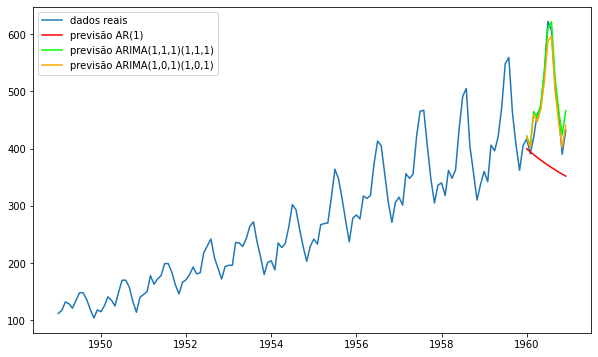

In [62]:
# Plotando a série com dados reais e ajustados pelo modelo
fig, ax = plt.subplots(figsize = (10,6), ncols = 1, nrows = 1)
plt.plot(st_passageiros_completa, label='dados reais')
plt.plot(previsao_arima_1_0_0,color='red', label='previsão AR(1)')
plt.plot(previsao_arima_1_1_1_1_1_1,color='lime', label='previsão ARIMA(1,1,1)(1,1,1)')
plt.plot(previsao_arima_1_0_1_1_0_1,color='orange', label='previsão ARIMA(1,0,1)(1,0,1)')
plt.legend(loc='best')
plt.show()

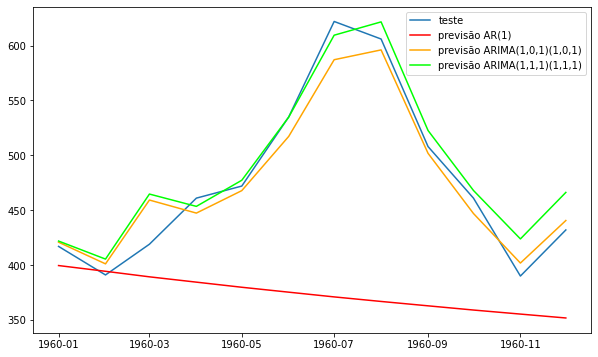

In [63]:
# Plotando a série com dados reais e ajustados pelo modelo
fig, ax = plt.subplots(figsize = (10,6), ncols = 1, nrows = 1)
plt.plot(st_passageiros_teste, label='teste')
plt.plot(previsao_arima_1_0_0, color='red', label='previsão AR(1)')
plt.plot(previsao_arima_1_0_1_1_0_1,color='orange', label='previsão ARIMA(1,0,1)(1,0,1)')
plt.plot(previsao_arima_1_1_1_1_1_1,color='lime', label='previsão ARIMA(1,1,1)(1,1,1)')
plt.legend(loc='best')
plt.show()

In [64]:
## Calculando métrica de avaliação do modelo de previsão
## erro médio absoluto (MAE) - meanabs
## raiz do erro quadrático médio (RMSE) - rmse

# Carregando bibliotecas necessárias
from statsmodels.tools.eval_measures import meanabs, rmse

# Calculando as métricas para previsão com ARIMA(1,0,1)(1,0,1)
mae_arima_1_0_0 = meanabs(st_passageiros_teste,previsao_arima_1_0_0)
rmse_arima_1_0_0 = rmse(st_passageiros_teste,previsao_arima_1_0_0)

# Calculando as métricas para previsão com ARIMA(1,0,1)(1,0,1)
mae_arima_1_0_1_1_0_1 = meanabs(st_passageiros_teste,previsao_arima_1_0_1_1_0_1)
rmse_arima_1_0_1_1_0_1 = rmse(st_passageiros_teste,previsao_arima_1_0_1_1_0_1)

# Calculando as métricas para previsão com ARIMA(1,1,1)(1,1,1)
mae_arima_1_1_1_1_1_1 = meanabs(st_passageiros_teste,previsao_arima_1_1_1_1_1_1)
rmse_arima_1_1_1_1_1_1 = rmse(st_passageiros_teste,previsao_arima_1_1_1_1_1_1)


In [65]:
# Comparando as métricas de avaliação das performances dos modelos de predição

print('\n Comparando os Erros Médios Absolutos')
print('AR(1): MAE = {}'.format(mae_arima_1_0_0))
print('ARIMA(1,0,1)(1,0,1): MAE = {}'.format(mae_arima_1_0_1_1_0_1))
print('ARIMA(1,1,1)(1,1,1): MAE = {}'.format(mae_arima_1_1_1_1_1_1))


print('\n Comparando as Raízes dos Erros Quadráticos Médios')
print('AR(1): RMSE = {}'.format(rmse_arima_1_0_0))
print('ARIMA(1,0,1)(1,0,1): RMSE = {}'.format(rmse_arima_1_0_1_1_0_1))
print('ARIMA(1,1,1)(1,1,1): RMSE = {}'.format(rmse_arima_1_1_1_1_1_1))




 Comparando os Erros Médios Absolutos
AR(1): MAE = 102.59715484775664
ARIMA(1,0,1)(1,0,1): MAE = 14.592291826490031
ARIMA(1,1,1)(1,1,1): MAE = 16.31452583214988

 Comparando as Raízes dos Erros Quadráticos Médios
AR(1): RMSE = 129.22275297261973
ARIMA(1,0,1)(1,0,1): RMSE = 18.29751967878156
ARIMA(1,1,1)(1,1,1): RMSE = 21.183739110543666


## **Modelos Box-Jenkins das série transformada**

### **Transformações**

#### **Transformação log**

In [66]:
# Aplicando log tornar tornar a série homocedástica
st_passageiros_log = np.log(st_passageiros)

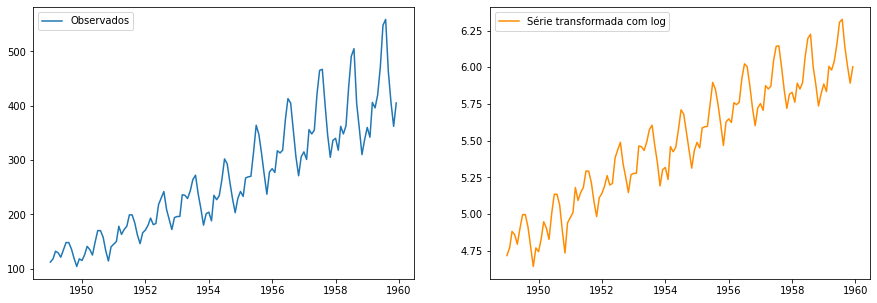

In [67]:
# Definindo o tamanho da figura
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

# Gráfico com valores observados
ax[0].plot(st_passageiros, label='Observados')
ax[0].legend(loc='upper left')

# Gráfico com transformação log
ax[1].plot(st_passageiros_log, color = 'darkorange', label='Série transformada com log')
ax[1].legend(loc='upper left')

# Exibindo o gráfico
plt.show()

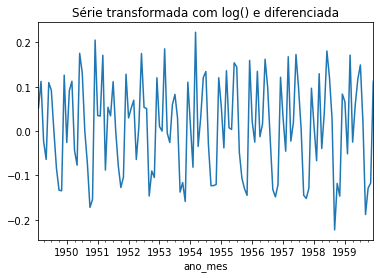

In [68]:
# Encontrando a diferença de primeira ordem da série transformada pelo log
st_passageiros_log_1_dif = st_passageiros_log.diff()

# Retirando o NA gerado pela falta de valores antes da primeira observação
st_passageiros_log_1_dif.dropna(inplace = True)

# Gerando o gráfico da série transformada e diferenciada
st_passageiros_log_1_dif.plot()
plt.title('Série transformada com log() e diferenciada')
plt.show()

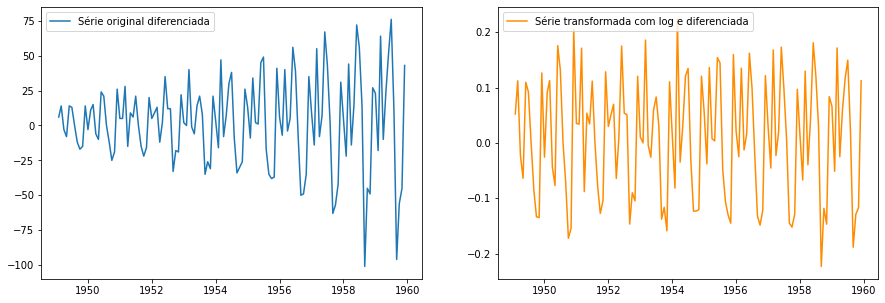

In [69]:
# Definindo o tamanho da figura
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

# Gráfico com primeira diferença da série original
ax[0].plot(st_passageiros_1_dif, label='Série original diferenciada')
ax[0].legend(loc='upper left')

# Gráfico com primeira diferença da série transformada
ax[1].plot(st_passageiros_log_1_dif, color = 'darkorange', label='Série transformada com log e diferenciada')
ax[1].legend(loc='upper left')

# Exibindo o gráfico
plt.show()

In [70]:
# Calculando as medidas do teste Dickey Fuller
# **Hipótese nula (Ho):** a série *não é estacionária*
# **Hipótese Alternativa (Ha):** a série *é estacionária*
df = statsmodels.tsa.stattools.adfuller(st_passageiros_log_1_dif)

print('Estatítica do teste: {:.4f}'.format(df[0]))
print('p-valor do teste: {:.8f}'.format(df[1]))
print('Valores Críticos:')
for chave, valor in df[4].items():
   print('{}: {:.4f}'.format(chave, valor))

Estatítica do teste: -3.0647
p-valor do teste: 0.02927720
Valores Críticos:
1%: -3.4875
5%: -2.8866
10%: -2.5801


#### **Transformação Box-Cox**

- $f_\lambda(x)=\frac{x^\lambda - 1}{\lambda}$ se $\lambda \neq 0$
- $f_\lambda(x)=log(x)$ se $\lambda=0$

In [71]:
# Importando biblioteca necessária
from scipy import stats

# Aplicando log tornar tornar a série homocedástica
passageiros_boxcox, lambda_boxcox_ajustado = stats.boxcox(st_passageiros)

# Valor do lambda ajustado
print('Valor do lambda da transformação Box-Cox: {:.4f}'.format(lambda_boxcox_ajustado))

Valor do lambda da transformação Box-Cox: 0.1289


In [72]:
# Espiando o resultado da transformação Box-Cox
passageiros_boxcox

array([6.49406644, 6.59024935, 6.79909207, 6.75602284, 6.63675271,
       6.84131689, 7.0153397 , 7.0153397 , 6.85521025, 6.60586377,
       6.35858573, 6.59024935, 6.5427044 , 6.71207206, 6.92337022,
       6.84131689, 6.69721912, 7.02816736, 7.28158846, 7.28158846,
       7.14035926, 6.81325907, 6.52661585, 6.90990857, 6.97639848,
       7.04092024, 7.37098998, 7.2003032 , 7.30427699, 7.37098998,
       7.5900162 , 7.5900162 , 7.43577198, 7.18844381, 6.98945624,
       7.23550499, 7.29296162, 7.39279256, 7.52957569, 7.40361483,
       7.42510401, 7.77146669, 7.87908761, 7.98192357, 7.68730997,
       7.50906486, 7.30427699, 7.53976176, 7.55999742, 7.55999742,
       7.93107504, 7.92249103, 7.87030842, 7.99029132, 8.15943155,
       8.22079327, 7.93962743, 7.70628052, 7.39279256, 7.60981044,
       7.63918247, 7.47794503, 7.92249103, 7.85264939, 7.91387513,
       8.15943155, 8.4377193 , 8.37468989, 8.12025275, 7.87030842,
       7.62943385, 7.87030842, 7.98192357, 7.9052271 , 8.18262

In [73]:
# Criando a  Serie temporal
st_passageiros_boxcox = pd.Series(
    data = passageiros_boxcox, 
    index = st_passageiros.index
)

# Espiando o resultado
st_passageiros_boxcox

ano_mes
1949-01-01    6.494066
1949-02-01    6.590249
1949-03-01    6.799092
1949-04-01    6.756023
1949-05-01    6.636753
                ...   
1959-08-01    9.775331
1959-09-01    9.354671
1959-10-01    9.072694
1959-11-01    8.820439
1959-12-01    9.062012
Freq: MS, Length: 132, dtype: float64

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html

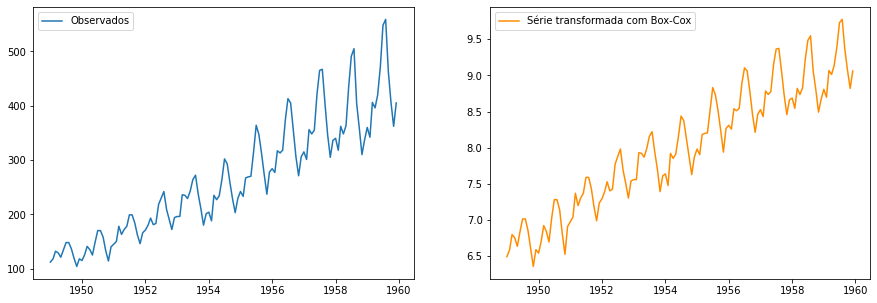

In [74]:
# Definindo o tamanho da figura
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

# Gráfico com primeira diferença da série original
ax[0].plot(st_passageiros, label='Observados')
ax[0].legend(loc='upper left')

# Gráfico com primeira diferença da série transformada
ax[1].plot(st_passageiros_boxcox, color = 'darkorange', label='Série transformada com Box-Cox')
ax[1].legend(loc='upper left')

# Exibindo o gráfico
plt.show()

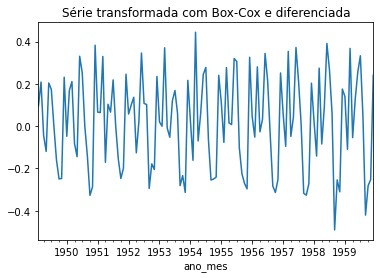

In [75]:
# Encontrando a diferença de primeira ordem da série transformada pela Box-Cox
st_passageiros_boxcox_1_dif = st_passageiros_boxcox.diff()

# Retirando o NA gerado pela falta de valores antes da primeira observação
st_passageiros_boxcox_1_dif.dropna(inplace = True)

# Gerando o gráfico da série transformada e diferenciada
st_passageiros_boxcox_1_dif.plot()
plt.title('Série transformada com Box-Cox e diferenciada')
plt.show()

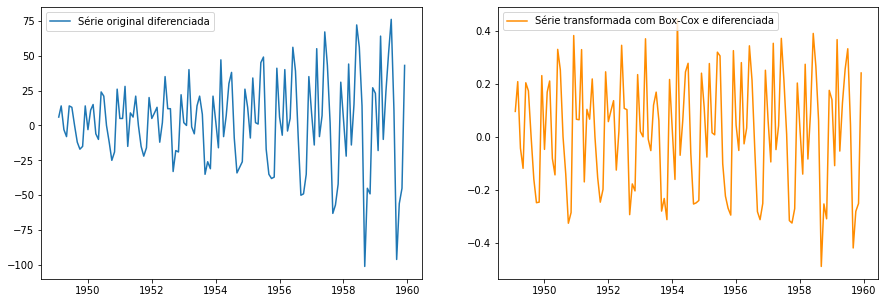

In [76]:
# Definindo o tamanho da figura
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

# Gráfico com primeira diferença da série original
ax[0].plot(st_passageiros_1_dif, label='Série original diferenciada')
ax[0].legend(loc='upper left')

# Gráfico com primeira diferença da série transformada
ax[1].plot(st_passageiros_boxcox_1_dif, color = 'darkorange', label='Série transformada com Box-Cox e diferenciada')
ax[1].legend(loc='upper left')

# Exibindo o gráfico
plt.show()

In [77]:
# Calculando as medidas do teste Dickey Fuller
# **Hipótese nula (Ho):** a série *não é estacionária*
# **Hipótese Alternativa (Ha):** a série *é estacionária*
df = statsmodels.tsa.stattools.adfuller(st_passageiros_boxcox_1_dif)

print('Estatítica do teste: {:.4f}'.format(df[0]))
print('p-valor do teste: {:.8f}'.format(df[1]))
print('Valores Críticos:')
for chave, valor in df[4].items():
   print('{}: {:.4f}'.format(chave, valor))

Estatítica do teste: -3.1139
p-valor do teste: 0.02554359
Valores Críticos:
1%: -3.4875
5%: -2.8866
10%: -2.5801


### **Auto Correlação da série transformada e diferenciada**

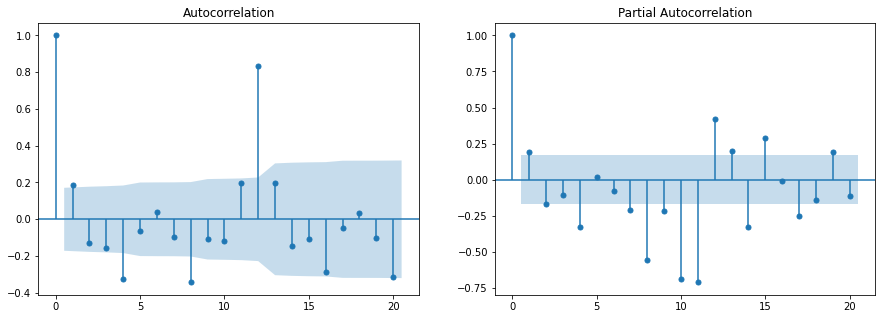

In [78]:
# Definindo o tamanho da figura e disposições dos subplots
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

 # Fazendo o gráfico de autocorrelação e autocorrelação  parcial
plot_acf(st_passageiros_log_1_dif, lags=20, ax=ax[0])
plot_pacf(st_passageiros_log_1_dif, lags=20, ax=ax[1])

# Exibindo o gráfico
plt.show()

### **Modelo ARIMA(1,0,1)(1,0,1)**

Um modelo ARIMA (p,d,q) com o grau de diferenciação igual a zero temos ARIMA(p,0,q) resulta em um modelo Auto regressivo e de média móvel de ordem p,q: ARMA(p,q). Para modelar também a sazonalidade insere os parâmetros (P,D,Q).

d:\virtualenv\kaggle\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
d:\virtualenv\kaggle\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


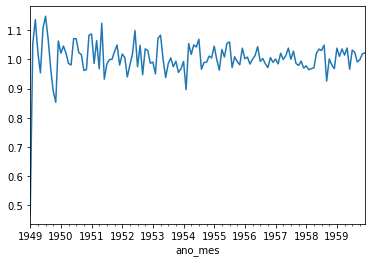

In [79]:
# Definindo Ajustando um modelo ARIMA(1,0,1)(1,0,1) com ajuste sazonal
modelo_arima_1_0_1_1_0_1 = statsmodels.tsa.arima.model.ARIMA(
    st_passageiros_log, 
    order = (1,0,1), 
    seasonal_order = (1, 0, 1, 12)
)

# Ajustando o modelo e guardando os resultado em um objeto
resultado_arima_1_0_1_1_0_1 = modelo_arima_1_0_1_1_0_1.fit()

# Pegando os resíduos do modelo
residuos_arima_1_0_1_1_0_1 = np.exp(resultado_arima_1_0_1_1_0_1.resid)

# Visualizando os resíduos
residuos_arima_1_0_1_1_0_1.plot()
plt.show()

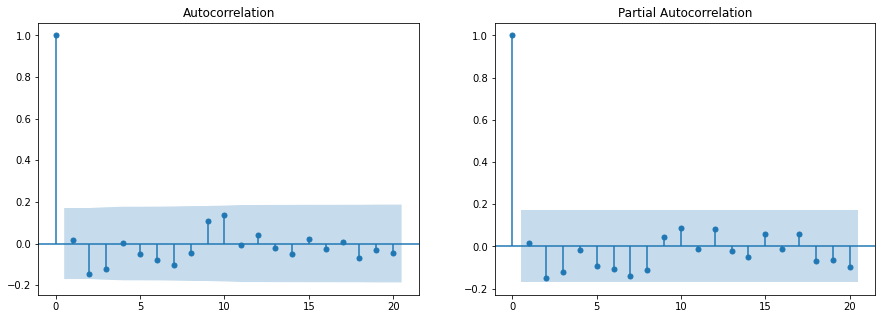

In [80]:
# Definindo o tamanho da figura e disposições dos subplots
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

 # Fazendo o gráfico de autocorrelação e autocorrelação  parcial
plot_acf(residuos_arima_1_0_1_1_0_1, lags=20, ax=ax[0])
plot_pacf(residuos_arima_1_0_1_1_0_1, lags=20, ax=ax[1])

# Exibindo o gráfico
plt.show()

C:\Users\roger\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


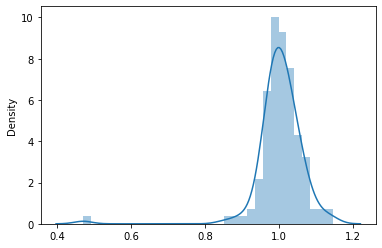

In [81]:
# Visualizando a distribuição dos resíduos
sns.distplot(residuos_arima_1_0_1_1_0_1);

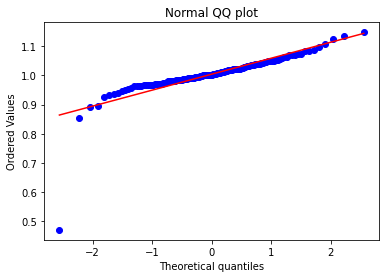

In [82]:
# Verificando a normalidade dos resíduos através do QQ plot
stats.probplot(residuos_arima_1_0_1_1_0_1, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

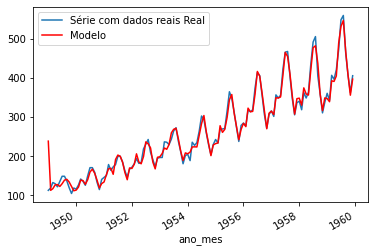

In [83]:
# Plotando a série com dados reais e ajustados pelo modelo
plt.plot(st_passageiros, label='Série com dados reais Real')
np.exp(resultado_arima_1_0_1_1_0_1.predict()).plot(color='red', label='Modelo')
plt.legend(loc='best')
plt.show()

### **Modelo ARIMA(1,1,1)(1,1,1)**

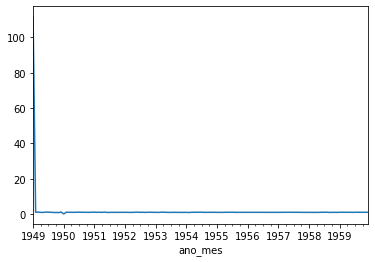

In [84]:
# Definindo Ajustando um modelo ARIMA(1,1,1)(1,1,1) com ajuste sazonal
modelo_arima_1_1_1_1_1_1 = statsmodels.tsa.arima.model.ARIMA(
    st_passageiros_log, 
    order = (1,1,1), 
    seasonal_order = (1, 1, 1, 12)
)

# Ajustando o modelo e guardando os resultado em um objeto
resultado_arima_1_1_1_1_1_1 = modelo_arima_1_1_1_1_1_1.fit()

# Pegando os resíduos do modelo
residuos_arima_1_1_1_1_1_1 = np.exp(resultado_arima_1_1_1_1_1_1.resid)

# Visualizando os resíduos
residuos_arima_1_1_1_1_1_1.plot()
plt.show()

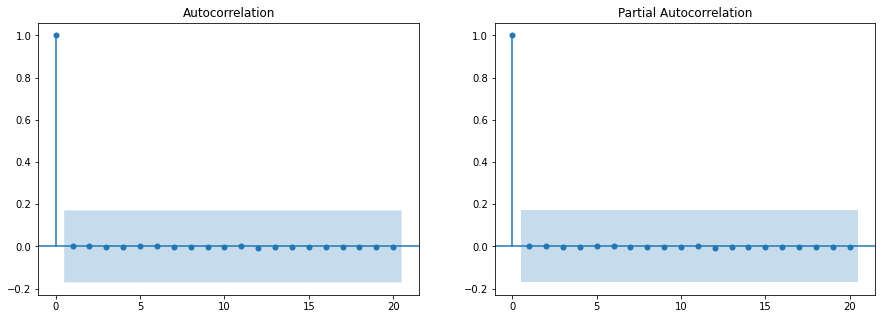

In [85]:
# Definindo o tamanho da figura e disposições dos subplots
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

 # Fazendo o gráfico de autocorrelação e autocorrelação  parcial
plot_acf(residuos_arima_1_1_1_1_1_1, lags=20, ax=ax[0])
plot_pacf(residuos_arima_1_1_1_1_1_1, lags=20, ax=ax[1])

# Exibindo o gráfico
plt.show()

C:\Users\roger\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


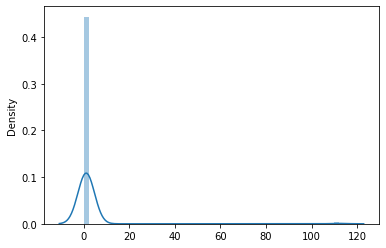

In [86]:
# Visualizando a distribuição dos resíduos
sns.distplot(residuos_arima_1_1_1_1_1_1);

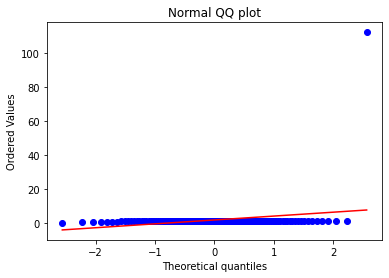

In [87]:
# Verificando a normalidade dos resíduos através do QQ plot
stats.probplot(residuos_arima_1_1_1_1_1_1, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

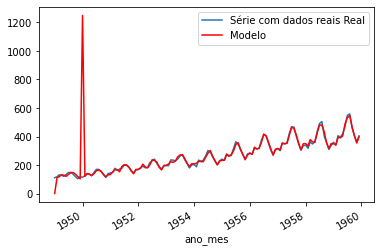

In [88]:
# Plotando a série com dados reais e ajustados pelo modelo
plt.plot(st_passageiros, label='Série com dados reais Real')
np.exp(resultado_arima_1_1_1_1_1_1.predict()).plot(color='red', label='Modelo')
plt.legend(loc='best')
plt.show()

### **Analisando o Critério de Informação de Akaike - AIC**

In [89]:
# Verificando o valor do Critério de Informação de Akaike - AIC
print('ARIMA(1,0,1)(1,0,1): AIC = {}'.format(resultado_arima_1_0_1_1_0_1.aic))
print('ARIMA(1,1,1)(1,1,1): AIC = {}'.format(resultado_arima_1_1_1_1_1_1.aic))

ARIMA(1,0,1)(1,0,1): AIC = -450.3143458094524
ARIMA(1,1,1)(1,1,1): AIC = -437.6830829534245


### **Previsão**

In [90]:
# Predizendo com o modelo ARIMA(1,0,1)(1,0,1)
previsao_arima_1_0_1_1_0_1_log = resultado_arima_1_0_1_1_0_1.forecast(12)
previsao_arima_1_0_1_1_0_1 = np.exp(previsao_arima_1_0_1_1_0_1_log)
previsao_arima_1_0_1_1_0_1

1960-01-01    418.146675
1960-02-01    397.000232
1960-03-01    461.631139
1960-04-01    448.740443
1960-05-01    466.386017
1960-06-01    535.792388
1960-07-01    606.629931
1960-08-01    613.254226
1960-09-01    512.772043
1960-10-01    450.492495
1960-11-01    396.692287
1960-12-01    438.957516
Freq: MS, Name: predicted_mean, dtype: float64

In [91]:
# Predizendo com o modelo ARIMA(1,1,1)(1,1,1)
previsao_arima_1_1_1_1_1_1_log = resultado_arima_1_1_1_1_1_1.forecast(12)
previsao_arima_1_1_1_1_1_1 = np.exp(previsao_arima_1_1_1_1_1_1_log)
previsao_arima_1_1_1_1_1_1

1960-01-01    418.130435
1960-02-01    396.684388
1960-03-01    463.265367
1960-04-01    450.940811
1960-05-01    469.729762
1960-06-01    544.458424
1960-07-01    618.757504
1960-08-01    627.079612
1960-09-01    522.997566
1960-10-01    459.061260
1960-11-01    403.436279
1960-12-01    448.047831
Freq: MS, Name: predicted_mean, dtype: float64

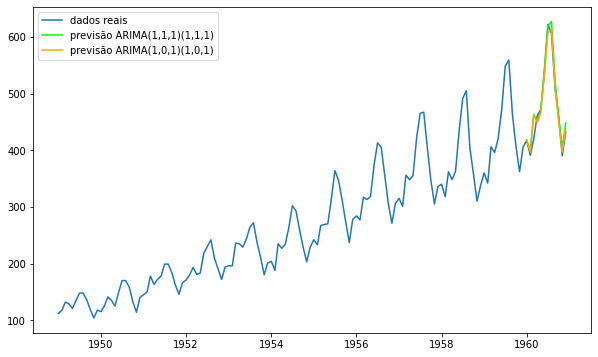

In [93]:
# Plotando a série com dados reais e ajustados pelo modelo
fig, ax = plt.subplots(figsize = (10,6), ncols = 1, nrows = 1)
plt.plot(st_passageiros_completa, label='dados reais')
plt.plot(previsao_arima_1_1_1_1_1_1,color='lime', label='previsão ARIMA(1,1,1)(1,1,1)')
plt.plot(previsao_arima_1_0_1_1_0_1,color='orange', label='previsão ARIMA(1,0,1)(1,0,1)')
plt.legend(loc='best')
plt.show()

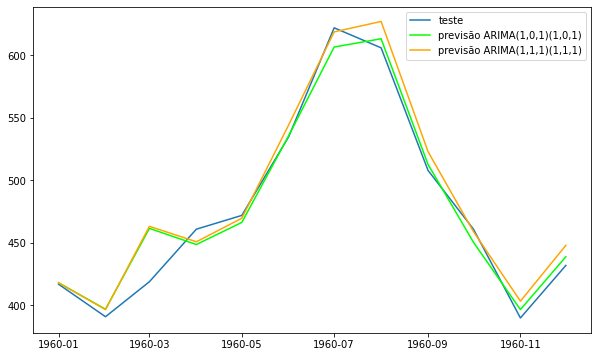

In [94]:
# Plotando a série com dados reais e ajustados pelo modelo
fig, ax = plt.subplots(figsize = (10,6), ncols = 1, nrows = 1)
plt.plot(st_passageiros_teste, label='teste')
plt.plot(previsao_arima_1_0_1_1_0_1,color='lime', label='previsão ARIMA(1,0,1)(1,0,1)')
plt.plot(previsao_arima_1_1_1_1_1_1,color='orange', label='previsão ARIMA(1,1,1)(1,1,1)')
plt.legend(loc='best')
plt.show()

In [95]:
## Calculando métrica de avaliação do modelo de previsão
## erro médio absoluto (MAE) - meanabs
## raiz do erro quadrático médio (RMSE) - rmse

# Carregando bibliotecas necessárias
from statsmodels.tools.eval_measures import meanabs, rmse

# Calculando as métricas para previsão com ARIMA(1,0,1)(1,0,1)
mae_arima_1_0_1_1_0_1 = meanabs(st_passageiros_teste,previsao_arima_1_0_1_1_0_1)
rmse_arima_1_0_1_1_0_1 = rmse(st_passageiros_teste,previsao_arima_1_0_1_1_0_1)

# Calculando as métricas para previsão com ARIMA(1,1,1)(1,1,1)
mae_arima_1_1_1_1_1_1 = meanabs(st_passageiros_teste,previsao_arima_1_1_1_1_1_1)
rmse_arima_1_1_1_1_1_1 = rmse(st_passageiros_teste,previsao_arima_1_1_1_1_1_1)

In [96]:
# Comparando as métricas de avaliação das performances dos modelos de predição
print('Comparando os Erros Médios Absolutos')
print('ARIMA(1,0,1)(1,0,1): MAE = {}'.format(mae_arima_1_0_1_1_0_1))
print('ARIMA(1,1,1)(1,1,1): MAE = {}'.format(mae_arima_1_1_1_1_1_1))

print('\n Comparando as Raízes dos Erros Quadráticos Médios')
print('ARIMA(1,0,1)(1,0,1): RMSE = {}'.format(rmse_arima_1_0_1_1_0_1))
print('ARIMA(1,1,1)(1,1,1): RMSE = {}'.format(rmse_arima_1_1_1_1_1_1))



Comparando os Erros Médios Absolutos
ARIMA(1,0,1)(1,0,1): MAE = 9.999801588247232
ARIMA(1,1,1)(1,1,1): MAE = 11.967547074901452

 Comparando as Raízes dos Erros Quadráticos Médios
ARIMA(1,0,1)(1,0,1): RMSE = 14.584265635209183
ARIMA(1,1,1)(1,1,1): RMSE = 16.609314435092507
